In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import math as m
pi = tf.constant(m.pi)

import qutip as qt
import matplotlib.pyplot as plt

In [126]:
"""
Initiate the model
"""
input_size = 1
timesteps = 30

input_layer = Input(shape = (None, timesteps))
hidden_1 = Dense(32, activation='relu',kernel_initializer='random_normal', 
                 bias_initializer='zeros')(input_layer)
branch_1_out = Dense(2 * timesteps, activation='tanh')(hidden_1)

Agent = Model(inputs=input_layer, outputs=branch_1_out)

In [127]:
def multivariate_gauss_prob(means, stdv, x):
    means_ = tf.broadcast_to(means, shape = x.shape)
    stdv_ = tf.broadcast_to(stdv, shape = x.shape)
    log_probabilities = -1* tf.math.log((1/stdv_ * tf.math.sqrt(2 * pi)) * tf.math.exp((-1/2) * ((x - means_) /(stdv_))**2))
#     print(probabilities)
    return tf.reduce_sum(log_probabilities, axis=1)

def get_params(agent_output):
    means = 2 * tf.squeeze(agent_output)[::2]
    stdv = (tf.squeeze(agent_output)[1::2] + 1.05)
    return means, stdv

def get_actions(means, stdv, batch_size=6):
    actions = tf.random.normal(shape=(batch_size,1), mean=means, stddev=stdv)
    return actions

In [128]:
"""
define basic single qubit env
"""
def evolve(actions_tf):
    max_time = 1
    actions = actions_tf.numpy()
    H_0 = qt.projection(2,0,1) + qt.projection(2,1,0)
    H = [H_0,actions]
    times = np.linspace(0,max_time, actions_tf.shape[0])
    rho_0 = qt.basis(2,0)
    result = qt.mesolve(H = H, tlist=times, rho0=rho_0)
    pops_list = []
    for i, state in enumerate(result.states):
        pop = np.abs(state.full()[1])**2
        pops_list.append(pop)
    max_pop = max(pops_list)
    return pops_list[-1], result.states

In [129]:
def get_loss(actions, rewards, means, stdvs, old_means, old_stdvs, eps=0.2):
    pi_a = multivariate_gauss_prob(means, stdvs, actions)
    pi_a_old = multivariate_gauss_prob(old_means, old_stdvs, actions)
#     print("pi_a: {}, pi_a_old: {}".format(pi_a, pi_a_old))
    ratio = pi_a / pi_a_old
#     print("ratio: ", ratio)
    clipped_ratio = tf.clip_by_value(ratio, clip_value_min=1-eps, clip_value_max=1+eps)
    objective = tf.minimum(ratio * rewards, clipped_ratio * rewards)
#     print("objective: {}".format(objective))
    loss = -1 * tf.reduce_mean(objective)
    return loss
    
    
def alternate_evolve(actions_tf):
    actions = actions_tf.numpy()
    x = np.arange(30)
    targ_dist = 2 * np.exp((-1/2) * (x - 15)**2/2**2) - 2
    
    loss = np.sum(np.abs(actions - targ_dist)**2)
    return -1 * loss

In [130]:
"""

"""
step=0
maxstep = 1000
constant_input = tf.random.uniform((1,timesteps), minval=-1, maxval=1)
optimizer = Adam(learning_rate=0.01)
while step<maxstep:
    with tf.GradientTape() as tape:
        net_outs = Agent(constant_input)
        means,sigmas = get_params(net_outs)
        if step==0:
            old_means = means
            old_stdvs = sigmas
        else:
            pass
        actions = get_actions(means=means, stdv=sigmas)
        rewards = []
        for i in range(actions.shape[0]):
            reward = alternate_evolve(actions[i])
            rewards.append(reward)
        rewards_tf = tf.Variable(rewards)
        print("Average Reward: ",tf.reduce_mean(rewards_tf).numpy())
        loss = get_loss(actions, rewards, means, sigmas,old_means=old_means, old_stdvs=old_stdvs)
        print("loss: {}".format(loss.numpy()))
    grads = tape.gradient(loss, Agent.trainable_variables)
    optimizer.apply_gradients(zip(grads, Agent.trainable_variables))
    old_means = means
    old_stdvs = sigmas
    step+=1

Average Reward:  -88.38336822994331
loss: 88.38336181640625
Average Reward:  -125.9034000911816
loss: 125.90340423583984
Average Reward:  -179.74573720228804
loss: 177.5757293701172
Average Reward:  -157.33130897084027
loss: 188.0041961669922
Average Reward:  -211.12172665761955
loss: 201.8096466064453
Average Reward:  -238.6927728421921
loss: 240.52796936035156
Average Reward:  -101.50891353992797
loss: 103.97040557861328
Average Reward:  -106.54477139689978
loss: 94.79309844970703
Average Reward:  -157.03244542276548
loss: 158.1193084716797
Average Reward:  -58.62601279314898
loss: 57.86319351196289
Average Reward:  -114.03804337603981
loss: 109.20992279052734
Average Reward:  -206.6389358590485
loss: 191.3730926513672
Average Reward:  -165.213989786689
loss: 167.09664916992188
Average Reward:  -197.91537270223913
loss: 189.25599670410156
Average Reward:  -181.03489738016125
loss: 208.17254638671875
Average Reward:  -107.24872811633334
loss: 99.2237548828125
Average Reward:  -105.611

Average Reward:  -371.9812425322162
loss: 371.948974609375
Average Reward:  -354.6907453414151
loss: 354.7183837890625
Average Reward:  -408.28136721816094
loss: 408.0583190917969
Average Reward:  -377.37081400392543
loss: 377.3148498535156
Average Reward:  -248.12191263290654
loss: 248.039794921875
Average Reward:  -673.8723319811962
loss: 673.535400390625
Average Reward:  -495.3338672074906
loss: 496.3318176269531
Average Reward:  -100.95669298119837
loss: 100.9635009765625
Average Reward:  -445.8659869689805
loss: 445.90966796875
Average Reward:  -574.2727183213595
loss: 574.2654418945312
Average Reward:  -605.4403867828838
loss: 605.4463500976562
Average Reward:  -212.0223810125117
loss: 212.019287109375
Average Reward:  -455.70661387396905
loss: 455.7310485839844
Average Reward:  -411.45137123295945
loss: 411.4405822753906
Average Reward:  -607.2735492760205
loss: 607.2376098632812
Average Reward:  -476.80909374404746
loss: 476.7657165527344
Average Reward:  -299.9964762358559
los

loss: 293.9594421386719
Average Reward:  -397.7222153845909
loss: 397.3375549316406
Average Reward:  -538.4434103957719
loss: 539.1043090820312
Average Reward:  -557.401399919531
loss: 556.2952270507812
Average Reward:  -607.0745217044491
loss: 608.3028564453125
Average Reward:  -666.80104097675
loss: 666.6829223632812
Average Reward:  -673.1228254900126
loss: 672.5968017578125
Average Reward:  -513.3096469137281
loss: 513.075439453125
Average Reward:  -568.926083168827
loss: 579.4866943359375
Average Reward:  -433.2654732483529
loss: 434.1891174316406
Average Reward:  -731.5267912876469
loss: 732.113037109375
Average Reward:  -828.9155903269575
loss: 832.482666015625
Average Reward:  -474.2224035563076
loss: 473.3389587402344
Average Reward:  -302.79482364547476
loss: 302.31640625
Average Reward:  -291.02453074985414
loss: 290.7904052734375
Average Reward:  -663.9241347849155
loss: 663.3699340820312
Average Reward:  -674.1656151095688
loss: 712.6393432617188
Average Reward:  -485.9425

Average Reward:  -439.41405436913647
loss: 439.3946838378906
Average Reward:  -631.2427048331483
loss: 631.3427124023438
Average Reward:  -132.8334743049695
loss: 132.8434295654297
Average Reward:  -357.09495003021465
loss: 357.0465087890625
Average Reward:  -650.5343036791742
loss: 650.5180053710938
Average Reward:  -461.8071806598122
loss: 461.7356262207031
Average Reward:  -458.25431550783
loss: 458.2137756347656
Average Reward:  -389.88038886948976
loss: 389.85498046875
Average Reward:  -283.27771551645316
loss: 283.2296142578125
Average Reward:  -540.9596005388283
loss: 540.9116821289062
Average Reward:  -572.514441541351
loss: 572.4503784179688
Average Reward:  -541.3268222465914
loss: 541.2609252929688
Average Reward:  -166.47337194311896
loss: 166.48316955566406
Average Reward:  -740.2567410903903
loss: 740.2526245117188
Average Reward:  -541.6793876209973
loss: 541.6343383789062
Average Reward:  -333.58554408754645
loss: 333.5790100097656
Average Reward:  -722.5993475302197
lo

Average Reward:  -527.1993450649724
loss: 527.21142578125
Average Reward:  -623.6247197667748
loss: 623.6216430664062
Average Reward:  -505.14233680600336
loss: 505.1125793457031
Average Reward:  -855.2679037038515
loss: 856.2130737304688
Average Reward:  -259.2546189398667
loss: 259.1433410644531
Average Reward:  -769.0202518971363
loss: 769.0573120117188
Average Reward:  -356.61079185438376
loss: 356.5705871582031
Average Reward:  -608.230182594198
loss: 607.9130859375
Average Reward:  -629.8308953131515
loss: 629.8652954101562
Average Reward:  -464.0637344486261
loss: 464.0954895019531
Average Reward:  -587.1945073616467
loss: 587.2865600585938
Average Reward:  -420.0880285996077
loss: 419.990478515625
Average Reward:  -329.1534744536843
loss: 329.1624450683594
Average Reward:  -503.10426586027006
loss: 502.6908264160156
Average Reward:  -293.81211910571847
loss: 293.7883605957031
Average Reward:  -224.94265183982063
loss: 224.93467712402344
Average Reward:  -413.4499899480813
loss:

loss: 519.8529663085938
Average Reward:  -469.44630921385436
loss: 468.6280822753906
Average Reward:  -692.054201829212
loss: 690.6058959960938
Average Reward:  -425.4926756142783
loss: 425.8294677734375
Average Reward:  -361.93913836165
loss: 361.8544006347656
Average Reward:  -690.9346993777026
loss: 690.685791015625
Average Reward:  -1034.3342419362334
loss: 1033.3321533203125
Average Reward:  -435.0017426394955
loss: 434.9073791503906
Average Reward:  -484.20772982618183
loss: 483.9129333496094
Average Reward:  -433.3925556892295
loss: 433.2292175292969
Average Reward:  -534.4002467096743
loss: 534.3722534179688
Average Reward:  -94.65400053284468
loss: 94.5870590209961
Average Reward:  -937.1131285938562
loss: 937.0935668945312
Average Reward:  -306.2713474370768
loss: 306.2217102050781
Average Reward:  -262.9242727985264
loss: 262.9212951660156
Average Reward:  -577.0888362524622
loss: 575.7689819335938
Average Reward:  -280.6490699412802
loss: 280.4042663574219
Average Reward:  

loss: 474.4082946777344
Average Reward:  -519.9120064043285
loss: 519.6929321289062
Average Reward:  -731.8201596237938
loss: 731.7872924804688
Average Reward:  -372.28723012676755
loss: 372.499267578125
Average Reward:  -469.1789869840009
loss: 469.2933044433594
Average Reward:  -609.3906156359218
loss: 609.340576171875
Average Reward:  -700.8826169066283
loss: 700.8523559570312
Average Reward:  -349.85373533297815
loss: 349.8228759765625
Average Reward:  -721.4290834160298
loss: 721.458984375
Average Reward:  -555.954852536514
loss: 555.9205932617188
Average Reward:  -520.6750635370021
loss: 520.5009765625
Average Reward:  -534.887811129189
loss: 534.9575805664062
Average Reward:  -472.8567898778845
loss: 472.8985595703125
Average Reward:  -677.2269818516257
loss: 677.193359375
Average Reward:  -656.5433197359785
loss: 656.2845458984375
Average Reward:  -541.9277836629614
loss: 541.9692993164062
Average Reward:  -566.591885564871
loss: 566.5818481445312
Average Reward:  -477.58966608

tf.Tensor(
[1.9471445 1.9718361 1.9286878 1.9753039 1.9876659 1.9831529 1.9790481
 1.9889104 1.9344295 1.9918096 1.9409397 1.9868166 1.9736608 1.82249
 1.9935304 1.9294093 1.9779651 1.9286388 1.7824751 1.9639648 1.9706211
 1.964364  1.9985431 1.9665005 1.9656386 1.9264215 1.9693136 1.9062482
 1.9975437 1.9814123], shape=(30,), dtype=float32)


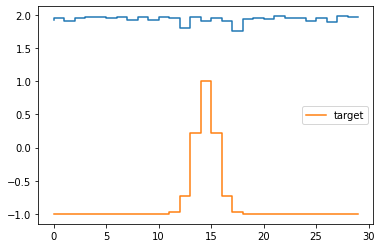

In [131]:

x = np.arange(30)
targ_dist = 2 * np.exp((-1/2) * (x - 15)**2) -1

net_out = Agent(constant_input)
mean, stdv = get_params(net_out)
print(mean)
actions = get_actions(mean, stdv/100, batch_size=1)
plt.figure(1)
plt.step(np.arange(timesteps),actions[0])
plt.step(np.arange(timesteps),targ_dist, label="target")
plt.legend()
# pop_final, state_his = evolve(actions[0])
# populations = np.zeros((len(state_his),2))
# for idx, state in enumerate(state_his):
#     populations[idx, 0] = np.abs(state.full()[0])**2
#     populations[idx, 1] = np.abs(state.full()[1])**2
# plt.figure(2)
# plt.plot(populations[:,0])
# plt.plot(populations[:,1])